In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

Altri test: least-square fitting, grafo pesato, phase-type distribution (con loss dipendente dai momenti)

Framework per profilazione: Cprofile
Settare numero massimo di core a 1, settare random_seed, macchina dedicata.

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [3]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [4]:
output_dist = start_SOGA(cfg, params_dict)

In [5]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]])>

In [6]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [7]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1389.279541015625
mean: 7.356147766113281 loss: 496.59661865234375
mean: 8.903613090515137 loss: 197.2566375732422
mean: 9.666125297546387 loss: 139.6145477294922
mean: 9.934993743896484 loss: 133.6276092529297
mean: 10.000572204589844 loss: 133.3180694580078
mean: 10.011005401611328 loss: 133.31109619140625
mean: 10.011916160583496 loss: 133.31106567382812
mean: 10.011931419372559 loss: 133.31105041503906
mean: 10.011931419372559 loss: 133.31105041503906


In [9]:
sampling_mean

tensor(10.)

In [10]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(133.3182)
Likelihood in the optimized distribution:  tensor(133.3111, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [12]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [13]:
output_dist = start_SOGA(cfg, params_dict)

In [14]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[10.]])
sigma: tensor([[[4.]]], grad_fn=<IndexBackward0>)>

In [15]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0096)


In [16]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1739.4129638671875
std: 1.4893995523452759 loss: 1550.503173828125
std: 1.0716763734817505 loss: 1432.2117919921875
std: 1.0054526329040527 loss: 1428.1802978515625
std: 1.009347915649414 loss: 1428.16259765625
std: 1.0092861652374268 loss: 1428.1624755859375
std: 1.0092650651931763 loss: 1428.16259765625
std: 1.0092672109603882 loss: 1428.1624755859375
std: 1.0092670917510986 loss: 1428.1624755859375
std: 1.0092670917510986 loss: 1428.1624755859375


In [17]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1428.2482)
Likelihood in the optimized distribution:  tensor(1428.1625, grad_fn=<NegBackward0>)


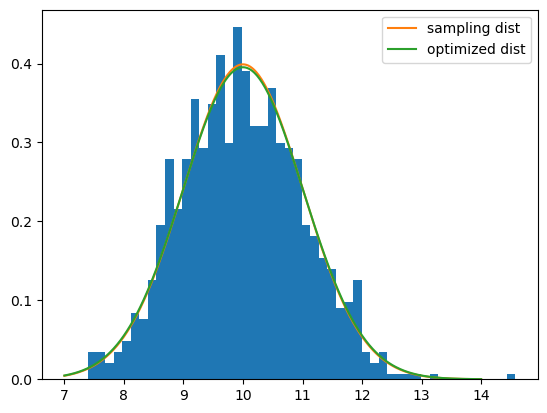

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [19]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [20]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [21]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [22]:
output_dist = start_SOGA(cfg, params_dict)

In [23]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[1.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]], grad_fn=<IndexBackward0>)>

In [24]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [25]:
torch.var(samples)

tensor(3.9519)

In [26]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [27]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3393.5947265625
par1: 1.4067553281784058 loss: 2353.156982421875
par1: 1.610129952430725 loss: 2187.670166015625
par1: 1.7342228889465332 loss: 2138.218994140625
par1: 1.8175599575042725 loss: 2119.279052734375
par1: 1.8750323057174683 loss: 2111.377197265625
par1: 1.9147920608520508 loss: 2107.9892578125
par1: 1.9420485496520996 loss: 2106.5419921875
par1: 1.9604160785675049 loss: 2105.9384765625
par1: 1.9725114107131958 loss: 2105.696044921875


In [28]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2105.5806)
Likelihood in the optimized distribution:  tensor(2105.6035, grad_fn=<NegBackward0>)


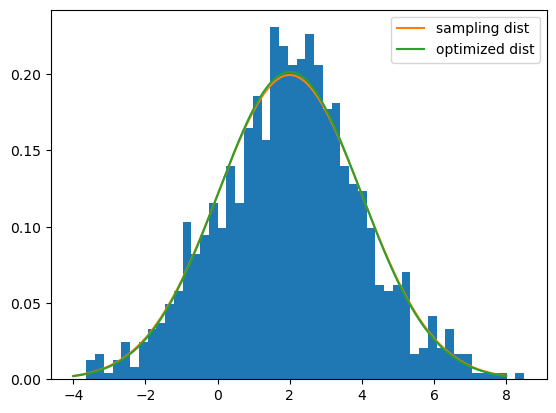

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [30]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [31]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [32]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [33]:
output_dist = start_SOGA(cfg, params_dict)

In [34]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[4.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[4.]]])>

In [35]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [36]:
torch.var(samples)

tensor(3.9518)

In [37]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2226.00146484375
par2: 1.9493284225463867 loss: 2214.1171875
par2: 1.900820016860962 loss: 2203.10498046875
par2: 1.853620171546936 loss: 2192.95458984375
par2: 1.8077442646026611 loss: 2183.623291015625
par2: 1.7632051706314087 loss: 2175.06787109375
par2: 1.7200161218643188 loss: 2167.245361328125
par2: 1.678189992904663 loss: 2160.114501953125
par2: 1.6377393007278442 loss: 2153.634765625
par2: 1.59867525100708 loss: 2147.765869140625


In [38]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2105.6147)
Likelihood in the optimized distribution:  tensor(2142.4685, grad_fn=<NegBackward0>)


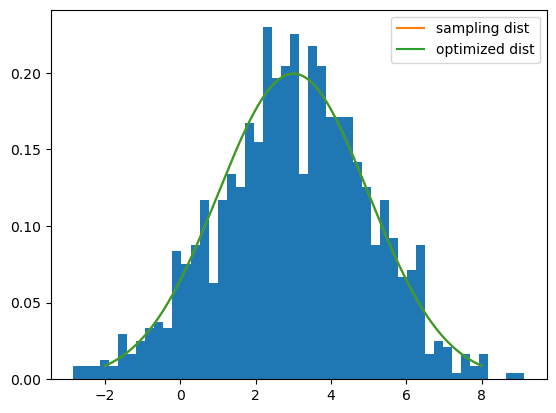

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [40]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [41]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [42]:
cfg.node_list

{'entry': EntryNode<>,
 'test0': TestNode<test0,gm([1.],[_mean],[1.])<0>,
 'state0': StateNode<state0,True,a=gm([1.],[-5.],[1.])>,
 'state1': StateNode<state1,False,a=gm([1.],[5.],[1.])>,
 'merge0': MergeNode<merge0>,
 'exit': ExitNode<>}

In [43]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [44]:
output_dist = start_SOGA(cfg, params_dict)

In [45]:
output_dist

Dist<['a'],pi: tensor([[0.3085],
        [0.6915]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [46]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

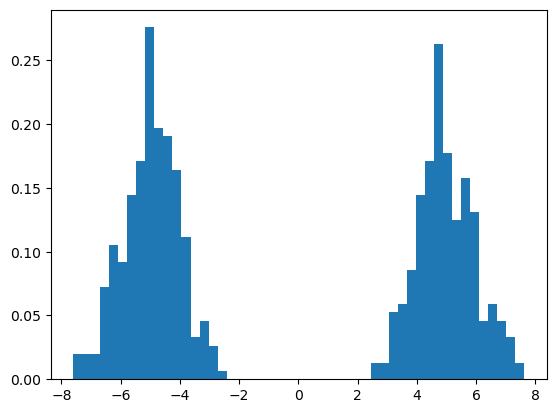

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [48]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [49]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)

    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1085.1455078125
mean: 0.2101358324289322 loss: 1049.4180908203125
mean: 0.029565589502453804 loss: 1039.6552734375
mean: -0.03507285192608833 loss: 1038.79833984375
mean: -0.0425918772816658 loss: 1038.7939453125
mean: -0.0404570996761322 loss: 1038.7928466796875
mean: -0.040004171431064606 loss: 1038.7928466796875
mean: -0.040111567825078964 loss: 1038.792724609375
mean: -0.040122173726558685 loss: 1038.792724609375
mean: -0.04011610522866249 loss: 1038.7928466796875


In [50]:
current_dist

Dist<['a'],pi: tensor([[0.5160],
        [0.4840]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [51]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1039.0488)
Likelihood in the optimized distribution:  tensor(1038.7928, grad_fn=<NegBackward0>)


In [52]:
output_dist

Dist<['a'],pi: tensor([[0.5160],
        [0.4840]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

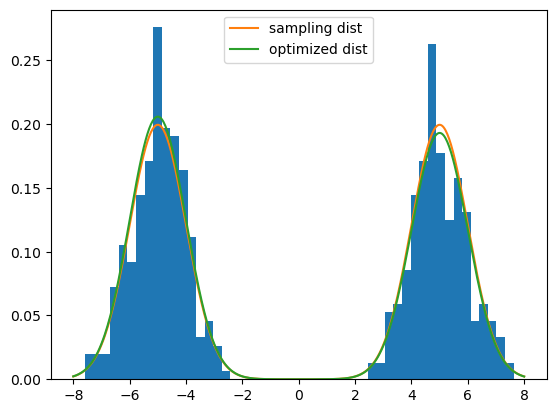

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [54]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [55]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [56]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [57]:
output_dist = start_SOGA(cfg, params_dict)

In [58]:
output_dist

Dist<['a'],pi: tensor([[0.6915],
        [0.3085]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [59]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

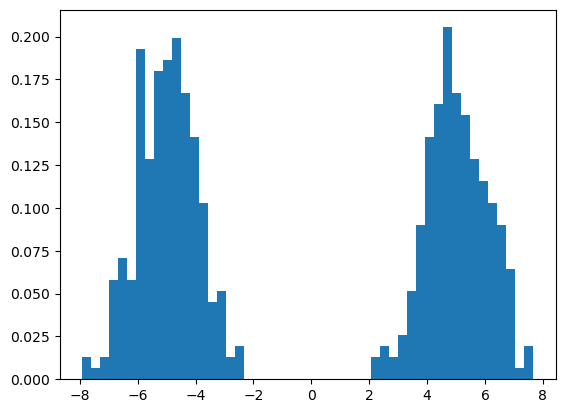

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [61]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1110.713134765625
coeff: 0.21414925158023834 loss: 1081.614990234375
coeff: 0.05806056037545204 loss: 1075.9208984375
coeff: 0.02473868802189827 loss: 1075.7744140625
coeff: 0.028874007984995842 loss: 1075.770263671875
coeff: 0.030412357300519943 loss: 1075.77001953125
coeff: 0.030083026736974716 loss: 1075.77001953125
coeff: 0.0300711989402771 loss: 1075.77001953125
coeff: 0.030087290331721306 loss: 1075.77001953125
coeff: 0.0300836693495512 loss: 1075.77001953125


In [62]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1075.9141)
Likelihood in the optimized distribution:  tensor(1075.7700, grad_fn=<NegBackward0>)


In [63]:
output_dist

Dist<['a'],pi: tensor([[0.5120],
        [0.4880]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

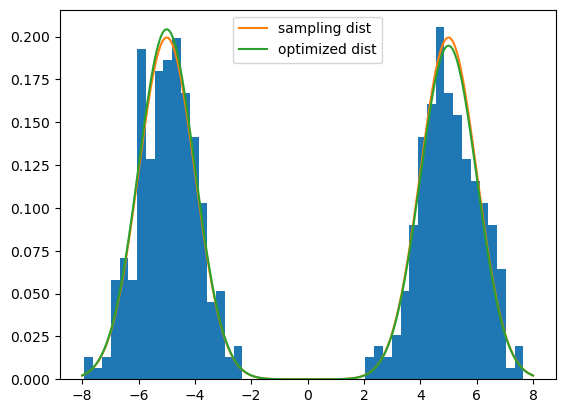

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [65]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [66]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [67]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [68]:
output_dist = start_SOGA(cfg, params_dict)

In [69]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[6.2500]]], grad_fn=<IndexBackward0>)>

In [70]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(0.9833)


In [71]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3900.853515625
mean: 5.880685329437256std: 3.22054123878479 loss: 2951.184326171875
mean: 6.570040702819824std: 3.4467098712921143 loss: 2689.846923828125
mean: 7.202298164367676std: 3.387779712677002 loss: 2520.27685546875
mean: 7.82930850982666std: 3.090357542037964 loss: 2343.17333984375
mean: 8.492725372314453std: 2.5429465770721436 loss: 2102.20166015625
mean: 9.246163368225098std: 1.693504810333252 loss: 1714.316650390625
mean: 9.941987037658691std: 0.9770180583000183 loss: 1402.7591552734375
mean: 9.985610961914062std: 0.982791006565094 loss: 1401.610595703125
mean: 9.985404014587402std: 0.982821524143219 loss: 1401.610595703125


In [72]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1402.0138)
Likelihood in the optimized distribution:  tensor(1401.6106, grad_fn=<NegBackward0>)


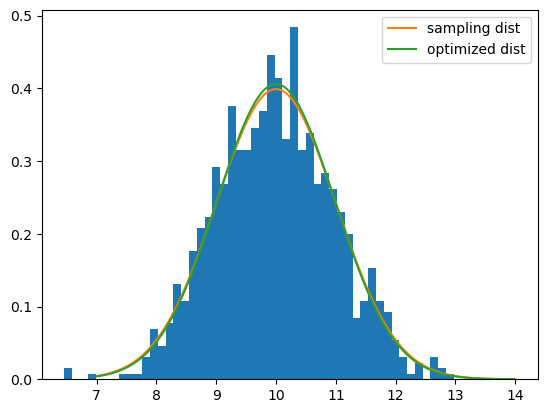

In [73]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(7,14,500).view(-1,1)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()